In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 12 08:30:19 2019
@author: andri
"""

import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
from operator import add

 #%% PART 1 %%#
 # Align the time series
 
rows_list = []
features_list =   []
features_list2=   []

path = 'C:/Users/andri/Desktop/Icelandair/'

counter = 0
with open(path+'sdata.csv', 'rb') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';') # Making use of reader method for reading the file
    for line in csv_reader: #Iterate through the loop to read line by line
        if counter<=362:
            rows_list.append(line)
        if counter>=756:
            features_list.append(line)
        counter+=1

for i in range(0, 359): 
    features_list2.append(features_list[i][1])

# Transpose data to make it same format as sample file
cols = np.array(rows_list).T.tolist()
features_cols = np.array(features_list2).T.tolist()

for i in range(0,4):
    features_list2.insert(len(features_list2),'NaN')

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)

df = pd.DataFrame(cols)
df = df[:][0:122] #only get data with dates
df=df.rename(columns={0: "Dates"})

df.to_csv ('output_dept_dates_aligned.csv', index = None, header=True)


# The dataframe is ready with all time series aligned (see below)
df


,Dates,1,2,3,4,...,358,359,360,361,362
0,01/10/17 00:00,,,,"222,02",...,"44680,74","35453,54","74761,01","53803,71","39496,7"
1,02/10/17 00:00,,,,,...,"35317,97","59414,86","31497,85","61297,56",33818
2,03/10/17 00:00,,,,,...,"37863,04","12145,93","18007,03","57726,61","24914,08"
3,04/10/17 00:00,,,,,...,"9330,35","13051,11","42523,96","36410,89","36257,89"
4,05/10/17 00:00,,,,"254,06",...,"6442,99","37959,58","37875,09","52255,59","42725,13"
5,06/10/17 00:00,,,,"1854,5",...,"29146,29","25947,22","25288,78","37617,88","37765,24"
6,07/10/17 00:00,,,,"1268,92",...,"16086,42","35334,69","27079,41","36727,29","27025,72"
7,08/10/17 00:00,"577,39",,"556,18","2846,17",...,"44371,32","43430,15","38856,87","36867,16","28208,83"
8,09/10/17 00:00,"95,38",,,"1237,24",...,"42926,71","42498,12","26926,82","41434,53","32214,35"
9,10/10/17 00:00,,,"116,32","275,32",...,"37597,8","40165,14","24319,58","69960,27","38741,04"


In [10]:
 #%% PART 1 %%# - Predict values for 2018

# Convert the decimal seperator from ',' to '.' so Python understands the numbers and they can be used for modeling
for i in range(1, 363):
    df[i] = (df[i].replace(',','.', regex=True))

# Assumption: missing values in the middle of the time series are zero
df.replace('', 0)

# Seperate 2017 and 2018 into different dataframes
years = []
for t in range (0, len(df)):
    year_temp = datetime.strptime(df['Dates'][t], '%d/%m/%y %H:%M').year
    years.append(year_temp)
df.insert(1, "Year", years, True) 

df2017 = df.loc[df['Year'] == 2017]
df2018 = df.loc[df['Year'] == 2018]

df2017.replace('', 0);
df2018.replace('', 0);

In [11]:
#%% MODEL SELECTION
# Model selection
# I decided to compare AR (Autoregression) and ARMA (combination of Autoregression and Moving Average)

# make predictions 
def make_prediction(fitted_model, training_set, validation_set): 
    prediction = fitted_model.predict(
        start=len(training_set), 
        end=len(training_set) + len(validation_set)-1, 
        dynamic=False)
    return prediction

error_list_AR = []
error_list_ARMA1 = []
error_list_ARMA2 = []

for i in range(202, 316):
    
    # Convert data to a format the model understands
    data = list(df2018[i])
    data = [float(x) for x in data]
    
    train_set, val_set, test_set = data[0:len(data)-10], data[len(data)-10:len(data)-5], data[len(data)-5:]
  
    # Train AR model
    AR_model = AR(train_set)
    AR_model_fitted = AR_model.fit()
    
    # Train ARMA models
    ARMA1_model = ARMA(data, order=(0, 1))
    ARMA1_model_fitted = ARMA1_model.fit(disp=False)
    
    ARMA2_model = ARMA(data, order=(0, 2))
    ARMA2_model_fitted = ARMA2_model.fit(disp=False)
    
    # Make prediction
    AR_pred   = make_prediction(AR_model_fitted, train_set, val_set)
    ARMA1_pred = make_prediction(ARMA1_model_fitted, train_set, val_set)
    ARMA2_pred = make_prediction(ARMA2_model_fitted, train_set, val_set)
    
    r2_AR   = r2_score(test_set, AR_pred)
    r2_ARMA1 = r2_score(test_set, ARMA1_pred)
    r2_ARMA2 = r2_score(test_set, ARMA2_pred)
    
    error_list_AR.append(r2_AR)
    error_list_ARMA1.append(r2_ARMA1)
    error_list_ARMA2.append(r2_ARMA2)
    
mse_AR = np.abs(np.mean(error_list_AR))
mse_ARMA1 = np.abs(np.mean(error_list_ARMA1))
mse_ARMA2 = np.abs(np.mean(error_list_ARMA2))

print "Mean squared error for the AR model: "+ str(mse_AR) 
print "Mean squared error for the ARMA(0,1) model: "+ str(mse_ARMA1) 
print "Mean squared error for the ARMA(0,2) model: "+ str(mse_ARMA2) 

# ARMA(0,2) has the lowest MSE so it will be used for forecasting
# NOTE: I ended up using ARMA(0,1), I ended up with errors I couldn't fix due to time constraints





C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\base\model.py:4

Mean squared error for the AR model: 3.845397449626739
Mean squared error for the ARMA(0,1) model: 3.9421642074070746
Mean squared error for the ARMA(0,2) model: 3.750994485309244


In [12]:
#%% Make predictions for each time series
# takes a while to run
counter=0
for c in range(317, 363):
    # make prediction
    data = list(df2018[c])
    data = [0 if x=='' else x for x in data]
    data = [float(y) for y in data]
        
    train_set, val_set = data[0:len(data)-(6+counter)], data[len(data)-(1+counter):len(data)]
      
    # Train AR model  
    ARMA2_model = ARMA(data, order=(0, 1))
    ARMA2_model_fitted = ARMA2_model.fit(disp=False)
    
    # Make prediction
    ARMA2_pred = make_prediction(ARMA2_model_fitted, train_set, val_set)
    ARMA2_pred = np.flip(ARMA2_pred, axis=0)
    
    for i in range(0, len(ARMA2_pred)):
        df2018[c][121-i] = ARMA2_pred[i]
    counter+=1
    


C:\Users\andri\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\andri\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


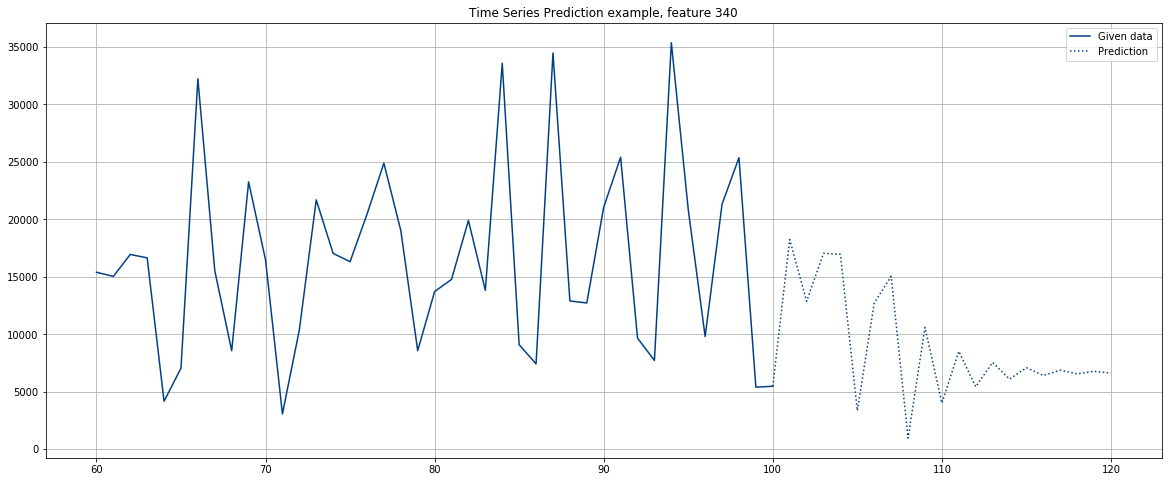

In [34]:
# Example of prediction for one of the time series
# This is what I did with all the incomplete time series (next cell)
data = list(df2018[335])
data = [float(x) for x in data]

# Plot the data
plt.plot(range(60, 121)[0:41],data[0:41], label='Given data', color='#013F85')
plt.plot(range(60, 121)[40:],data[40:], label='Prediction', color='#013F85', linestyle=':')
plt.title('Time Series Prediction example, feature 340')
plt.rcParams['figure.figsize'] = [20, 8]
plt.grid()
plt.legend()
plt.show();

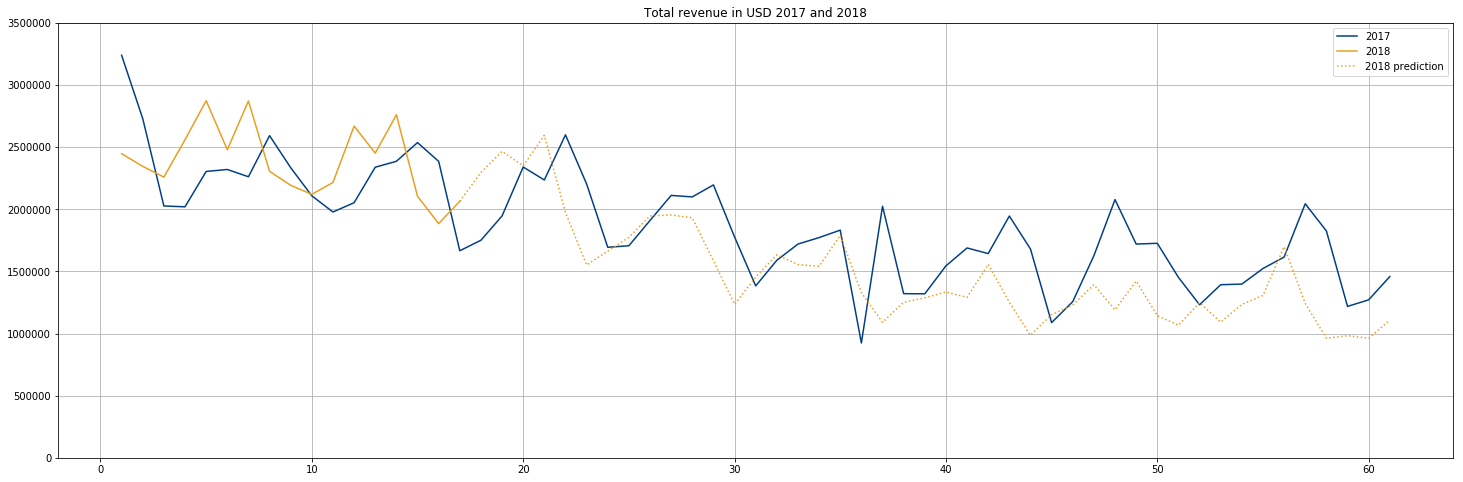

In [33]:
# Prepare the data and predictions for YoY graph
totals_2017 = [0] * 61
totals_2018 = [0] * 61

for i in range(1,363):
    data2017 = list(df2017[i])   
    data2017 = [0 if x=='' else x for x in data2017]
    data2017 = [float(x) for x in data2017]
    totals_2017 = list( map(add, totals_2017, data2017) )
    
    data2018 = list(df2018[i])   
    data2018 = [0 if x=='' else x for x in data2018]
    data2018 = [float(x) for x in data2018]
    totals_2018 = list( map(add, totals_2018, data2018) )

# Plot YoY graph with the total revenue prediction
plt.plot(range(1, 62),totals_2017, label='2017', color='#013F85')
plt.plot(range(1, 62)[0:17],totals_2018[0:17], label='2018', color='#EB9E1E')
plt.plot(range(1, 62)[16:],totals_2018[16:], label='2018 prediction', color='#EB9E1E', linestyle=':')
plt.grid()
plt.legend()
plt.title('Total revenue in USD 2017 and 2018')

axes = plt.gca()
axes.set_ylim([0,3500000])#np.max(totals_2017)+1000])
plt.rcParams['figure.figsize'] = [20, 8]

plt.show()


In [35]:
get_notebook_name()

NameError: name 'get_notebook_name' is not defined